<a href="https://colab.research.google.com/github/amankc/Fall24---Modeling/blob/main/mod03_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Initial Setup**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Soil column properties
zs = 500.0 # Depth of soil [cm]
dz = 15.0   # Numerical model layer thickness [cm]

# Soil properties (obtained from https://doi.org/10.1029/2017JF004535)
Cs = 635.0 # Heat capacity of soil/permafrost [J/(kg K)]
ks = 0.25  # Thermal conductivity of soil/permafrost [W/(m K)]
rhos = 920.0 # Bulk density of permafrost [kg/m^3]

dt = 1 # Time step [day]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**1. Load and Plot the Air Temperature Trends**

In [ ]:
data = np.loadtxt('/content/drive/MyDrive/Fa2024-Modeling/mod3/PermafrostTemperatureScenarios.csv', delimiter=',', skiprows=1)

t_year = data[:,0]
T_15 = data[:,1]
T_30 = data[:,2]
T_45 = data[:,3]

Text(0, 0.5, 'Annual average air temperature [°C]')

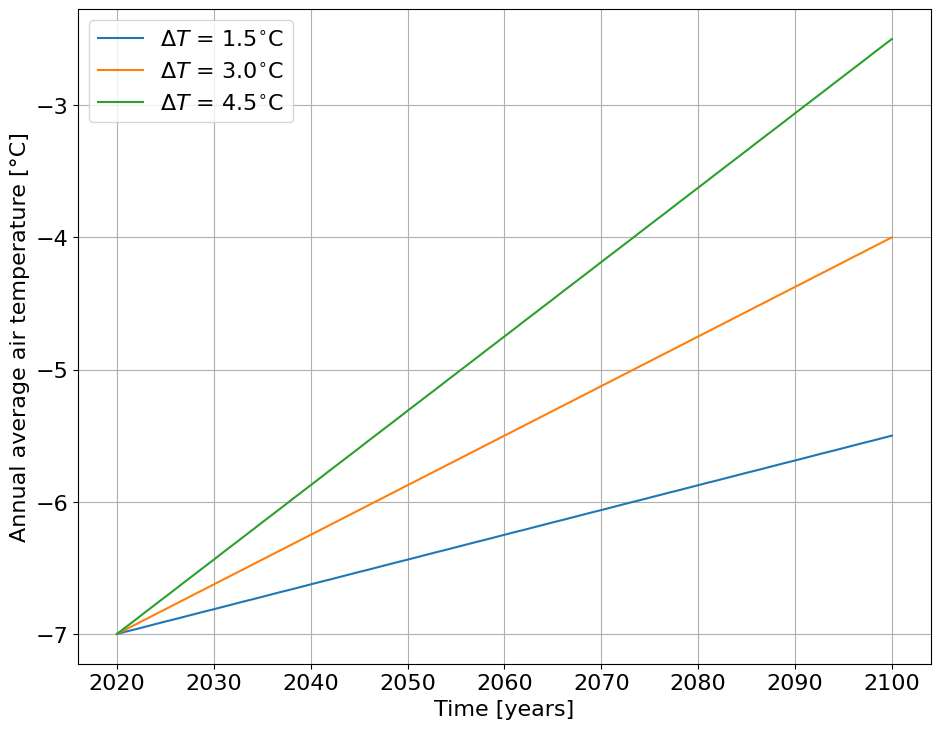

In [ ]:
## First off, let's change the font size for all of our plots to be more legible
plt.rcParams.update({'font.size': 16})

plt.figure(figsize=(11.0,8.5))
plt.plot(t_year,T_15,label='$\Delta T$ = 1.5${}^{\circ}$C')
plt.plot(t_year,T_30,label='$\Delta T$ = 3.0${}^{\circ}$C')
plt.plot(t_year,T_45,label='$\Delta T$ = 4.5${}^{\circ}$C')
plt.legend(loc='upper left')
plt.grid()
plt.xlabel('Time [years]')
plt.ylabel('Annual average air temperature [°C]')

**2. Setup the Simulation Time Period**

In [ ]:
# Time properties of simulation
t0 = t_year[0]
tf = t_year[-1]

t = np.arange(t0,tf+(dt/365),(dt/365))
Nt = t.size
print('The number of time steps: Nt = ',str(Nt))

The number of time steps: Nt =  29201


**3. Setup Boundary Conditions**

In [ ]:
# Boundary conditions
Ttopamp = 35.0
Tbottom = -7.0

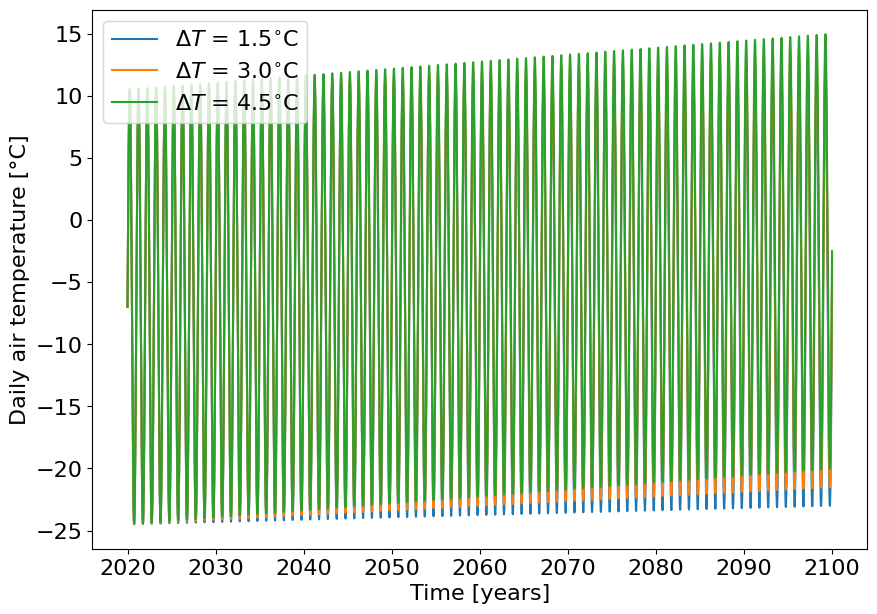

In [ ]:
Ttop_15 = np.interp(t, t_year, T_15) + (Ttopamp/2.0)*np.sin((2.0*np.pi)*t)
Ttop_30 = np.interp(t, t_year, T_30) + (Ttopamp/2.0)*np.sin((2.0*np.pi)*t)
Ttop_45 = np.interp(t, t_year, T_45) + (Ttopamp/2.0)*np.sin((2.0*np.pi)*t)

plt.figure(figsize=(10.0,7.0))
plt.plot(t, Ttop_15, label='$\Delta T$ = 1.5${}^{\circ}$C')
plt.plot(t, Ttop_30, label='$\Delta T$ = 3.0${}^{\circ}$C')
plt.plot(t, Ttop_45, label='$\Delta T$ = 4.5${}^{\circ}$C')
plt.xlabel('Time [years]')
plt.ylabel('Daily air temperature [°C]')
plt.legend(loc='upper left')
plt.show()

**4. Setup Spatial Domain**

In [ ]:
# Ts = np.zeros((Nz,Nt))
z = np.arange(dz/2, zs, dz)
Nz = z.size
print('Here are the locations of our cells: z = \n' + str(z))
print('The number of cells is: Nz = ',str(Nz))

Here are the locations of our cells: z = 
[  7.5  22.5  37.5  52.5  67.5  82.5  97.5 112.5 127.5 142.5 157.5 172.5
 187.5 202.5 217.5 232.5 247.5 262.5 277.5 292.5 307.5 322.5 337.5 352.5
 367.5 382.5 397.5 412.5 427.5 442.5 457.5 472.5 487.5]
The number of cells is: Nz =  33


**5. Setup Initial Condition**

In [ ]:
Ts0 = Tbottom*np.ones((Nz,1))

alpha = ks / (rhos * Cs)
print('Soil diffusivity = '+str(alpha)+' m^2/s')

# Convert alpha to units consistent with domain [cm^2/day]
alpha = alpha*(100.0**2)*(24.0*3600.0)
print('Soil diffusivity = '+str(alpha)+' cm^2/day')

s = alpha*dt/(dz**2)
print('Stability criterion '+str(s))

Soil diffusivity = 4.279356384799726e-07 m^2/s
Soil diffusivity = 369.7363916466963 cm^2/day
Stability criterion 1.6432728517630946


**6. Calculate A, B, and D Matrices for Implicit or Crank-Nicolson Method**

In [ ]:
A = np.diag((1 + 2.0*alpha)*np.ones((Nz))) + \
    np.diag(-alpha*np.ones((Nz-1)),1) + \
    np.diag(-alpha*np.ones((Nz-1)),-1)

A[0,:] = np.hstack((1.0,np.zeros((Nz-1))))
A[-1,:] = np.hstack((np.zeros((Nz-1)),1.0))

print(A)

[[   1.            0.            0.         ...    0.
     0.            0.        ]
 [-369.73639165  740.47278329 -369.73639165 ...    0.
     0.            0.        ]
 [   0.         -369.73639165  740.47278329 ...    0.
     0.            0.        ]
 ...
 [   0.            0.            0.         ...  740.47278329
  -369.73639165    0.        ]
 [   0.            0.            0.         ... -369.73639165
   740.47278329 -369.73639165]
 [   0.            0.            0.         ...    0.
     0.            1.        ]]


In [ ]:
B = np.diag((1 - 2.0*alpha)*np.ones((Nz))) + \
    np.diag(alpha*np.ones((Nz-1)),1) + \
    np.diag(alpha*np.ones((Nz-1)),-1)

B[0,:] = np.hstack((1.0,np.zeros((Nz-1))))
B[-1,:] = np.hstack((np.zeros((Nz-1)),1.0))

print(B)

[[   1.            0.            0.         ...    0.
     0.            0.        ]
 [ 369.73639165 -738.47278329  369.73639165 ...    0.
     0.            0.        ]
 [   0.          369.73639165 -738.47278329 ...    0.
     0.            0.        ]
 ...
 [   0.            0.            0.         ... -738.47278329
   369.73639165    0.        ]
 [   0.            0.            0.         ...  369.73639165
  -738.47278329  369.73639165]
 [   0.            0.            0.         ...    0.
     0.            1.        ]]


**7. Preallocate Storage for Soil Temperatures**

In [228]:
Ts = np.zeros((Nz,Nt))

**8. Apply Solution And Compute Temperatures**

In [229]:
scenarios = [Ttop_15,Ttop_30,Ttop_45]
Ts_ind= [];
for k in range(len(scenarios)):
  Ttop = scenarios[k]

  for i in np.arange(Nt):
      if(i==0):
          Tsi = Ts0
      else:
          Tsi = Ts[:,i-1]
          Tsi[0] = Ttop[i]
          Tsi[-1] = Tbottom

      Tsip1 = np.matmul(np.matmul(np.linalg.pinv(A),B), Tsi)

      Ts[:,i] = np.squeeze(Tsip1)
  Ts_ind.append(Ts)

1. A plot of 3 x 2 subplots of the vertical temperature distribution with time. Each row should correspond to each of the 3 climate change scenarios with the top row being the ΔT = 1.5 &deg;C, the middle being ΔT = 3.0&deg;C, and the bottom row being ΔT= 4.5&deg;C. The left column should correspond to the first 10 years of simulation, and the right column the last 10 years of simulation.

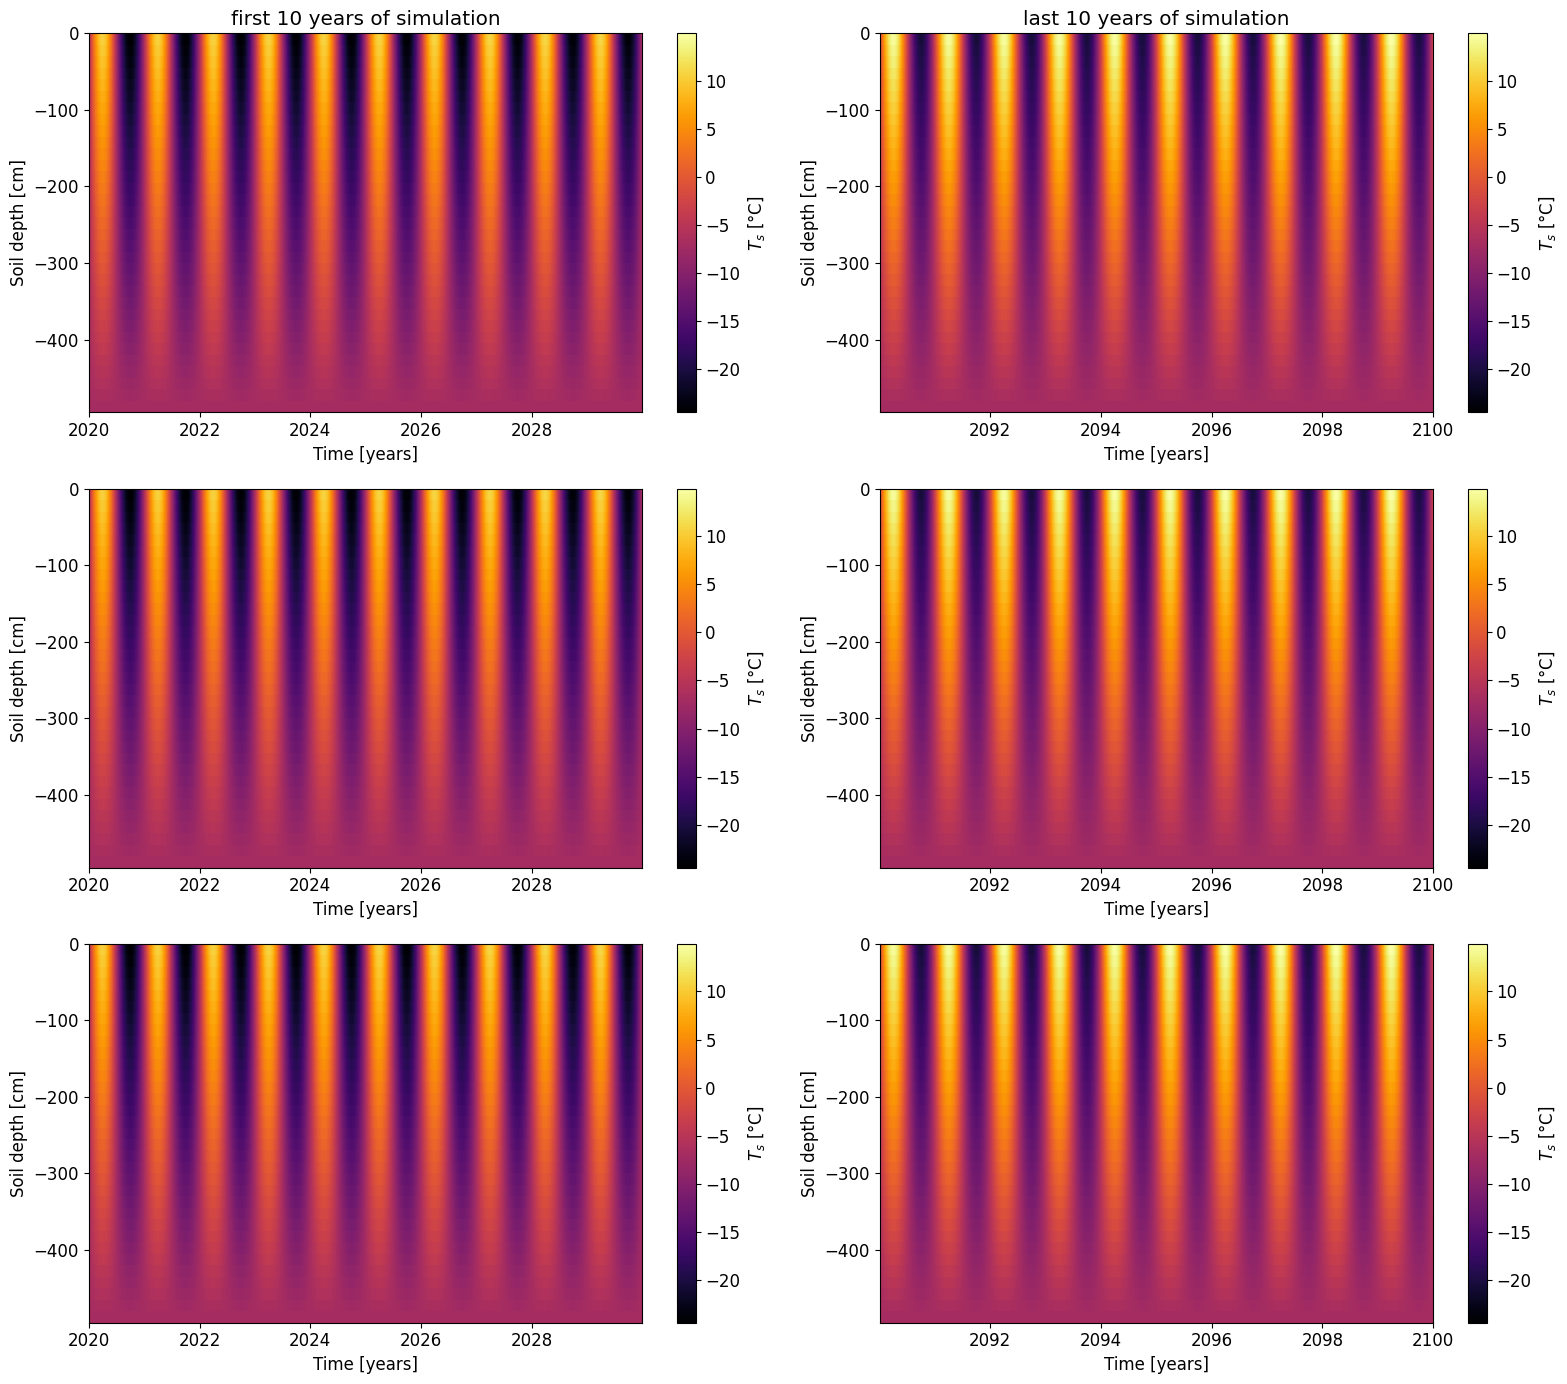

In [230]:

first_10_years = slice(0, 10 * 365)  # First 10 years in days
last_10_years = slice(-10 * 365, None)  # Last 10 years in days

tt, zz = np.meshgrid(t[:first_10_years.stop], z)
min = []; max = [];
for Ts in Ts_ind:
  min.append(Ts.min())
  max.append(Ts.max())
global_min = np.min(min)
global_max = np.max(max)
# global_max = max([Ts.max() for Ts in Ts_ind])
plt.rcParams.update({'font.size': 12})
rows = 3; cols = 2;
fig, ax = plt.subplots(rows, cols, figsize=(16, 14))
for i in range(rows):
    for j in range(cols):
        Ts_all = Ts_ind[i]
        if j == 0:
            Ts_plot = Ts_all[:, first_10_years]
            tt, zz = np.meshgrid(t[first_10_years],z)
        else:
            Ts_plot = Ts_all[:, last_10_years]
            tt, zz = np.meshgrid(t[last_10_years], z)



        # ax[i, j].pcolormesh(tt, -zz, Ts_plot, cmap='inferno', shading='auto')
        pcm = ax[i, j].pcolormesh(tt, -zz, Ts_plot, cmap='inferno', shading='auto',
                                  vmin=global_min, vmax=global_max)
        if i == 0 and j==0:
          ax[i, j].set_title('first 10 years of simulation')
        elif i == 0 and j==1:
          ax[i, j].set_title('last 10 years of simulation')

        ax[i, j].set_xlabel('Time [years]')
        ax[i, j].set_ylabel('Soil depth [cm]')


        # fig.colorbar(ax[i, j].collections[0], ax=ax[i, j], label='$T_s$ [°C]')
        fig.colorbar(pcm, ax=ax[i, j], label='$T_s$ [°C]')

plt.tight_layout()
plt.show()

2. A plot of 2 x 2 subplots of the temperature at four different levels. One subplot of temperature versus time for all three scenarios at a depth of 50 cm, the second subplot the same information at 100 cm, the third subplot the same information at 200 cm, and the fourth subplot the same information at 400 cm.

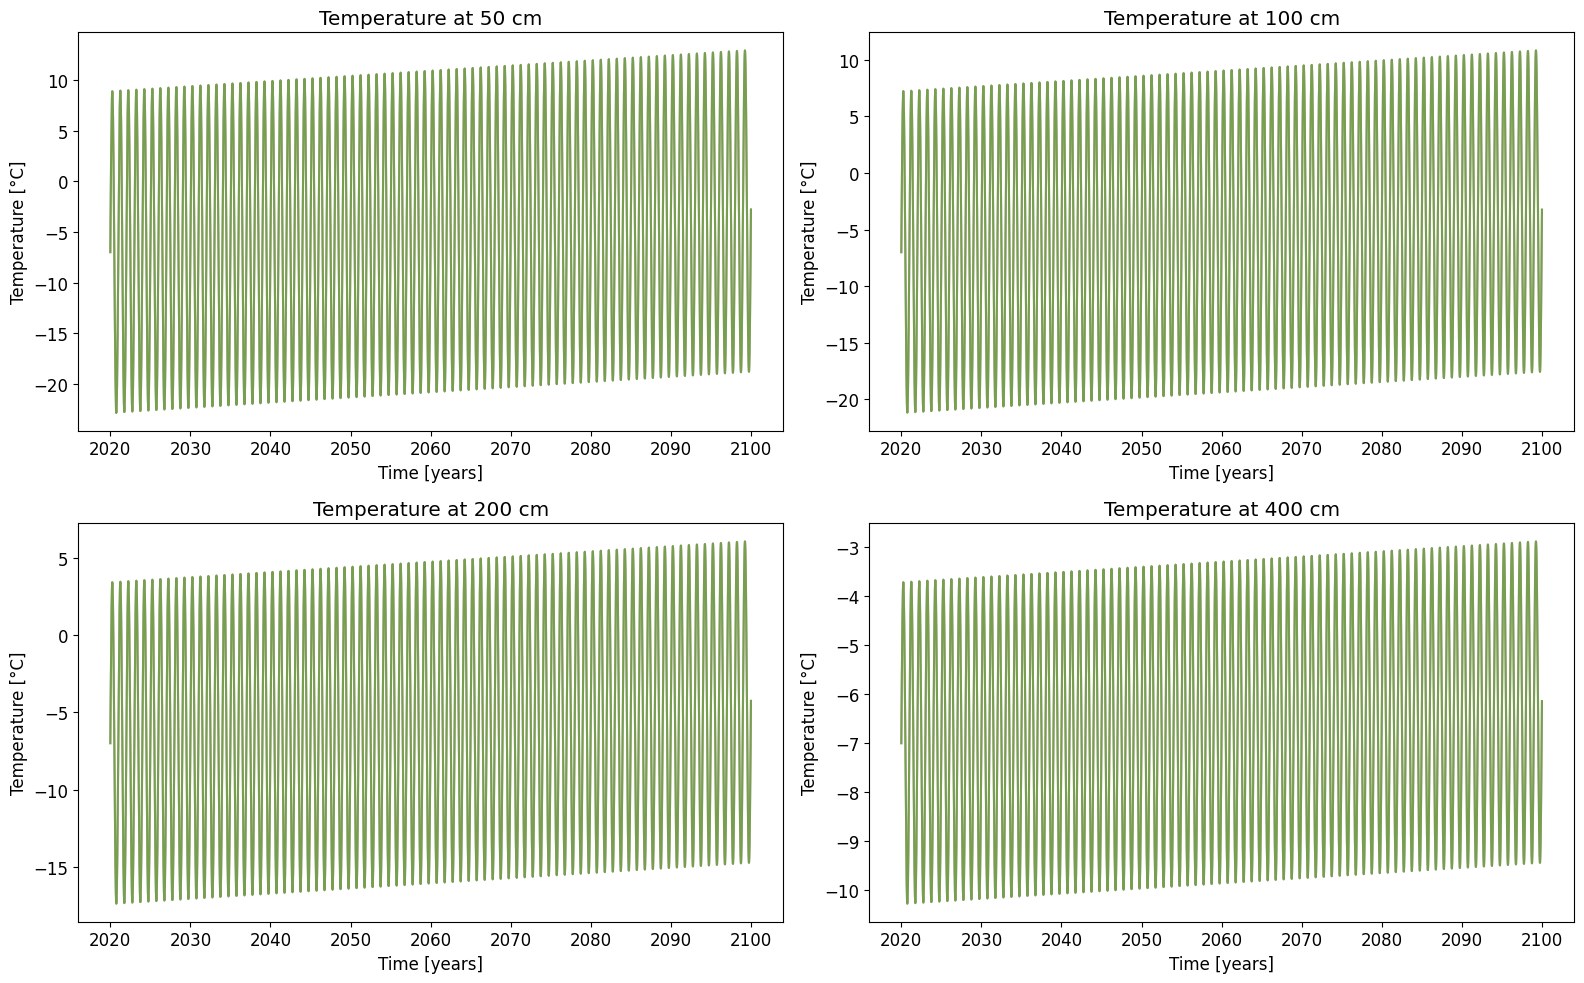

In [231]:
iz50 = (np.absolute(z - 50.0)).argmin()
iz100 = (np.absolute(z - 100.0)).argmin()
iz200 = (np.absolute(z - 200.0)).argmin()
iz400 = (np.absolute(z - 400.0)).argmin()


iz_array = [iz50, iz100, iz200, iz400]
depths = [50, 100, 200, 400]


rows = 2
cols = 2
fig, ax = plt.subplots(rows, cols, figsize=(16, 10))

a = 0

for i in range(rows):
    for j in range(cols):
        for k in range(len(scenarios)):
            Ts = Ts_ind[k]
            ax[i, j].plot(t, Ts[iz_array[a], :],alpha = 0.5)

        ax[i, j].set_title(f'Temperature at {depths[a]} cm')
        ax[i, j].set_xlabel('Time [years]')
        ax[i, j].set_ylabel('Temperature [°C]')
        a += 1

plt.tight_layout()
plt.show()


3. A markdown table showing the approximate depth of the active layer for each scenario for the first, a middle, and the final decade of the simulation.

In [234]:
first_decade_end = 10 * 365 - 1  # End of the first 10 years
middle_decade_end = Nt // 2  # Middle point of the entire simulation (around the middle decade)
final_decade_end = Nt - 1  # End of the entire simulation

depths = z; active_first = []; active_middle=[];active_end = [];
scenarios_labels = ['1.5°C', '3.0°C', '4.5°C']

def find_active_layer_depth(Ts, depth_array):
    for i, temp in enumerate(Ts):
        if temp <= 0:
            return depth_array[i]

for s_label, Ts in zip(scenarios_labels, Ts_ind):

    temp_first_decade = Ts[:, first_decade_end]
    active_first.append(find_active_layer_depth(temp_first_decade, depths))

    temp_middle_decade = Ts[:, middle_decade_end]
    active_middle.append(find_active_layer_depth(temp_middle_decade, depths))

    temp_final_decade = Ts[:, final_decade_end]
    active_end.append(find_active_layer_depth(temp_final_decade, depths))



In [237]:
print(active_first)
print(active_middle)
print(active_end)

[7.5, 7.5, 7.5]
[7.5, 7.5, 7.5]
[7.5, 7.5, 7.5]


| Decade        | 1.5&deg;C Active Layer Depth (cm) | 3&deg;C Active Layer Depth (cm) | 4.5&deg;C Active Layer Depth (cm) |
|---------------|-------------------------------|-------------------------------|-------------------------------|
| First Decade  | 7.5 cm                          | 7.5 cm                          | 7.5 cm                          |
| Middle Decade | 7.5 cm                          | 7.5 cm                          | 7.5 cm                          |
| Final Decade  | 7.5 cm                          | 7.5 cm                          | 7.5 cm                          |
